In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
os.chdir('F:/PhD/2nd Year Paper')  # Replace with your desired directory path
print(os.getcwd())  # Verify the change

F:\PhD\2nd Year Paper


In [26]:
# Load the dataset
file_path = 'F:/PhD/2nd Year Paper/Data/data.csv'  # Update this to the correct path if needed
data = pd.read_csv(file_path)

filtered_data = data[data['class'] == 'province'].copy()

## Time trend:
filtered_data['t'] = filtered_data['year'] - 1995
filtered_data['t2'] = filtered_data['t'] ** 2

# List of provinces for `treat1 = 25`
special_provinces = ['beijing', 'tianjin', 'shanghai', 'chongqing', 'fujian', 'hebei']

In [27]:
## OLS Model
# Generate `treat` column
filtered_data['treat'] = 0.0  # Initialize with 0

# Each round is for one year
# 2019: Trial City 25 types 1 year, nontrial 25 types 1/3 of the year
filtered_data.loc[(filtered_data['name'].isin(special_provinces)) & (filtered_data['year'] == 2019), 'treat'] = 25
filtered_data.loc[(~filtered_data['name'].isin(special_provinces)) & (filtered_data['year'] == 2019), 'treat'] = 25 / 3

# 2020: 32 types 11/12 year & 55 types 1/3 year
filtered_data.loc[(filtered_data['name'].isin(special_provinces)) & (filtered_data['year'] == 2019), 'treat'] = 352/12 + 55/3
filtered_data.loc[(~filtered_data['name'].isin(special_provinces)) & (filtered_data['year'] == 2019), 'treat'] = 352/12 + 55/3 +50/3

# 2021: 45 types 11/12 year & 61 types 1/2 year and  & 1 type 1/12 year
filtered_data.loc[(filtered_data['year'] == 2021), 'treat'] = 32/12 + 110/3 + 495/12 + 61/2 + 1/12

# 2022: 61 type 1/6
filtered_data.loc[(filtered_data['year'] == 2022), 'treat'] = 45/12+ 61/2 + 11/12 + 61/6

In [28]:
# Genrate OLS pre model
filtered_data['treatols19'] = 0  # Initialize with 0
filtered_data ['treatols20'] = 0
filtered_data.loc[(filtered_data['name'].isin(special_provinces)) & (filtered_data['year'] >= 2019), 'treatols19'] = 1
filtered_data.loc[(filtered_data['year'] > 2019), 'treatols20'] = 1

In [29]:
## One year effect
# Generate Event Study
filtered_data['round1'] = 0.0  # Initialize with 0
filtered_data.loc[(filtered_data['name'].isin(special_provinces)) & (filtered_data['year'] == 2019), 'round1'] = 25
filtered_data.loc[(~filtered_data['name'].isin(special_provinces)) & (filtered_data['year'] == 2019), 'round1'] = 25 / 3
filtered_data.loc[(~filtered_data['name'].isin(special_provinces)) & (filtered_data['year'] == 2020), 'round1'] = 50 / 3

filtered_data['round2'] = 0.0  # Initialize with 0
filtered_data.loc[(filtered_data['year'] ==2020), 'round2'] = 352/12
filtered_data.loc[(filtered_data['year'] ==2021), 'round2'] = 32/12

filtered_data['round3'] = 0.0  # Initialize with 0
filtered_data.loc[(filtered_data['year'] ==2020), 'round3'] = 55/3
filtered_data.loc[(filtered_data['year'] ==2021), 'round3'] = 110/3

filtered_data['round4'] = 0.0  # Initialize with 0
filtered_data.loc[(filtered_data['year'] ==2021), 'round4'] = 495/12
filtered_data.loc[(filtered_data['year'] ==2022), 'round4'] = 45/12

filtered_data['round5'] = 0.0  # Initialize with 0
filtered_data.loc[(filtered_data['year'] ==2021), 'round5'] = 61/2
filtered_data.loc[(filtered_data['year'] ==2022), 'round5'] = 61/2

filtered_data['round6'] = 0.0  # Initialize with 0
filtered_data.loc[(filtered_data['year'] ==2021), 'round6'] = 1/12
filtered_data.loc[(filtered_data['year'] ==2022), 'round6'] = 11/12

filtered_data['round7'] = 0.0  # Initialize with 0
filtered_data.loc[(filtered_data['year'] ==2021), 'round7'] = 305/12

In [30]:
## Long lasting effect simple
filtered_data['treat19'] = 0.0  # Initialize with 0
filtered_data.loc[(filtered_data['year'] >=2019), 'treat19'] = 25

filtered_data['treat20'] = 0.0  # Initialize with 0
filtered_data.loc[(filtered_data['year'] >=2020), 'treat20'] = 87

filtered_data['treat21'] = 0.0  # Initialize with 0
filtered_data.loc[(filtered_data['year'] >=2021), 'treat21'] = 108

filtered_data['treat22'] = 0.0  # Initialize with 0
filtered_data.loc[(filtered_data['year'] >=2022), 'treat22'] = 61


In [32]:
output_path = 'F:/PhD/2nd Year Paper/Data/filtered_data.csv'  # Update the path as needed
filtered_data.to_csv(output_path, index=False)
print(f"Filtered data has been exported to: {output_path}")

Filtered data has been exported to: F:/PhD/2nd Year Paper/Data/filtered_data.csv


## Start here

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from econml.dml import DML
from sklearn.linear_model import Lasso
import statsmodels.api as sm
import statsmodels.formula.api as smf
## ML Treatment
file_path = 'F:/PhD/2nd Year Paper/Data/filtered_data.csv'  # Update this to the correct path if needed
data = pd.read_csv(file_path)
filtered_data = data.dropna(subset=['hexpf_adjusted'])
filtered_data.loc[:, 'mltreat'] = (filtered_data['treatols19'] | filtered_data['treatols20']).astype(int)
filtered_data.loc[:, 'year'] = pd.to_numeric(filtered_data['year'], errors='coerce')  # Convert year to numeric
filtered_data['mltreat'] = filtered_data['mltreat'].astype(int)
lag_vars = ['hexpf_adjusted', 'hos_num', 'annual_patient', 'gdp_adjusted', 'population', 'mltreat']
for var in lag_vars:
    filtered_data[f'{var}_lag1'] = filtered_data.groupby('name')[var].shift(1)
special_provinces = ['beijing', 'tianjin', 'shanghai', 'chongqing', 'fujian', 'hebei']

C:\Users\yizho\AppData\Local\Temp\ipykernel_12836\158899098.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'mltreat'] = (filtered_data['treatols19'] | filtered_data['treatols20']).astype(int)
C:\Users\yizho\AppData\Local\Temp\ipykernel_12836\158899098.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['mltreat'] = filtered_data['mltreat'].astype(int)
C:\Users\yizho\AppData\Local\Temp\ipykernel_12836\158899098.py:23: SettingWithCopyWarning: 
A value is trying to be 

## Simple OLS

In [34]:
model = smf.ols(
    formula="hexpf_adjusted ~ mltreat + gdp_adjusted + hos_num  + annual_patient + C(region) + C(year)", 
    data=filtered_data[filtered_data['year'] < 2020]
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         hexpf_adjusted   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     70.76
Date:                Wed, 30 Jul 2025   Prob (F-statistic):          9.07e-147
Time:                        01:19:11   Log-Likelihood:                -3603.3
No. Observations:                 527   AIC:                             7259.
Df Residuals:                     501   BIC:                             7369.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1181.29

In [49]:
model = smf.ols(
    formula="hexpf_adjusted ~ mltreat + hexpf_adjusted_lag1 + gdp_adjusted + hos_num + population + annual_patient + C(name) ",
    data=filtered_data[~filtered_data['name'].isin(special_provinces)]
).fit(cov_type='HC1')

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         hexpf_adjusted   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     259.1
Date:                Wed, 30 Jul 2025   Prob (F-statistic):          6.42e-268
Time:                        01:52:06   Log-Likelihood:                -3107.6
No. Observations:                 500   AIC:                             6277.
Df Residuals:                     469   BIC:                             6408.
Df Model:                          30                                         
Covariance Type:                  HC1                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

D:\anaconda\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 30, but rank is 29
  warnings.warn('covariance of constraints does not have full '


In [ ]:
model = smf.ols(
    formula="hexpf_adjusted ~ mltreat + hexpf_adjusted_lag1 + gdp_adjusted + hos_num + population + annual_patient + C(name) + C(year)",
    data=filtered_data[~filtered_data['name'].isin(special_provinces)]
).fit(cov_type='HC1')

# Print the summary
print(model.summary())

In [35]:
model = smf.ols(
    formula="hexpf_adjusted ~ mltreat + hexpf_adjusted_lag1 + gdp_adjusted + hos_num + population + C(name) + C(year)", 
    data=filtered_data[filtered_data['year'] < 2020]
).fit(cov_type='HC1')

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         hexpf_adjusted   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     2206.
Date:                Wed, 30 Jul 2025   Prob (F-statistic):               0.00
Time:                        01:19:12   Log-Likelihood:                -3115.7
No. Observations:                 527   AIC:                             6335.
Df Residuals:                     475   BIC:                             6557.
Df Model:                          51                                         
Covariance Type:                  HC1                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

D:\anaconda\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 59, but rank is 52
  warnings.warn('covariance of constraints does not have full '


In [47]:
model = smf.ols(formula="hexpf_adjusted ~ treat + hexpf_adjusted_lag1 + gdp_adjusted + population + hos_num + C(name) + C(year)", data=filtered_data).fit(cov_type='HC1')


# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         hexpf_adjusted   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     2151.
Date:                Wed, 30 Jul 2025   Prob (F-statistic):               0.00
Time:                        01:31:44   Log-Likelihood:                -3752.1
No. Observations:                 620   AIC:                             7614.
Df Residuals:                     565   BIC:                             7858.
Df Model:                          54                                         
Covariance Type:                  HC1                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

D:\anaconda\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 62, but rank is 55
  warnings.warn('covariance of constraints does not have full '


## Transfering to ML can add annual patient Concentration rate in the future

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from econml.dml import DML
from sklearn.linear_model import Lasso
## ML Treatment
file_path = 'F:/PhD/2nd Year Paper/Data/filtered_data.csv'  # Update this to the correct path if needed
data = pd.read_csv(file_path)
filtered_data = data.dropna(subset=['hexpf_adjusted'])
filtered_data.loc[:, 'mltreat'] = (filtered_data['treatols19'] | filtered_data['treatols20']).astype(int)
filtered_data.loc[:, 'year'] = pd.to_numeric(filtered_data['year'], errors='coerce')  # Convert year to numeric
filtered_data['mltreat'] = filtered_data['mltreat'].astype(int)

C:\Users\yizho\AppData\Local\Temp\ipykernel_12836\3627143791.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'mltreat'] = (filtered_data['treatols19'] | filtered_data['treatols20']).astype(int)
C:\Users\yizho\AppData\Local\Temp\ipykernel_12836\3627143791.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['mltreat'] = filtered_data['mltreat'].astype(int)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from econml.dml import DML
from sklearn.linear_model import Lasso
## ML Treatment
file_path = 'F:/PhD/2nd Year Paper/Data/filtered_data.csv'  # Update this to the correct path if needed
data = pd.read_csv(file_path)
filtered_data = data.dropna(subset=['hexpf_adjusted']).copy()
filtered_data.loc[:, 'mltreat'] = (filtered_data['treatols19'] | filtered_data['treatols20']).astype(int)
filtered_data.loc[:, 'year'] = pd.to_numeric(filtered_data['year'], errors='coerce')  # Convert year to numeric
filtered_data['mltreat'] = filtered_data['mltreat'].astype(int)
print("Number of observations:", filtered_data.shape[0])

Number of observations: 866


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from econml.dml import CausalForestDML
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Step 1: Sort and construct lags
#filtered_data = filtered_data[~filtered_data['name'].str.lower().isin(special_provinces)]
special_provinces = ['beijing', 'tianjin', 'shanghai', 'chongqing', 'fujian', 'hebei']
filtered_data['special'] = filtered_data['name'].str.lower().isin(special_provinces).astype(int)

# Drop the special provinces
filtered_data = filtered_data[filtered_data['special'] == 0].copy()
filtered_data = filtered_data.sort_values(by=['name', 'year']).reset_index(drop=True)

lag_vars = ['hexpf_adjusted', 'hos_num', 'gdp_adjusted', 'population', 'mltreat','annual_patient']
for var in lag_vars:
    filtered_data[f'{var}_lag1'] = filtered_data.groupby('name')[var].shift(1)

# Step 2: Drop rows with missing lag values
filtered_data = filtered_data.dropna(subset=[f'{v}_lag1' for v in lag_vars])
print("Number of observations:", filtered_data.shape[0])

# Step 3: Define outcome and treatment
Y = filtered_data['hexpf_adjusted']      # Level outcome
T = filtered_data['mltreat']             # Treatment indicator



# Create lagged variable names
lag_vars = ['hexpf_adjusted', 'hos_num', 'gdp_adjusted', 'population', 'annual_patient']
lagged_columns = [f'{v}_lag1' for v in lag_vars]

# Base continuous variables (without year)
X_continuous = filtered_data[['hos_num', 'gdp_adjusted', 'population', 'annual_patient'] + lagged_columns]

# Categorical variables (province names and year as fixed effects)
X_categorical = pd.get_dummies(filtered_data[['name', 'year']].astype(str), drop_first=True)

# Step 5: Build X for treatment and outcome models
X_y = pd.concat([X_continuous, X_categorical], axis=1)  # Outcome model includes year FE
X_t = pd.concat([X_continuous, X_categorical.drop(columns=[col for col in X_categorical.columns if col.startswith('year_')])], axis=1)


# Step 4: Construct covariates
#X_continuous = filtered_data[
#    ['hos_num', 'gdp_adjusted', 'population', 'annual_patient', 'year'] +
#    [f'{v}_lag1' for v in ['hexpf_adjusted', 'hos_num', 'gdp_adjusted', 'population', 'annual_patient']]
#]
#X_categorical = pd.get_dummies(filtered_data[['name']], drop_first=True)

# Step 5: Build separate X for treatment and outcome models
#X_y = pd.concat([X_continuous, X_categorical], axis=1)                   # Outcome model (with year)
#X_t = pd.concat([X_continuous.drop(columns=['year']), X_categorical], axis=1)
#X_t = filtered_data[['hos_num', 'gdp_adjusted', 'population','annual_patient']].copy()



Number of observations: 475


In [5]:
# Step 6: Fit CausalForestDML
outcome_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
treatment_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=500, random_state=42)

cf_dml = CausalForestDML(
    model_y=outcome_model,
    model_t=treatment_model,
    discrete_treatment=True,
    n_estimators=100,
    min_samples_leaf=5,
    max_depth=10,
    random_state=42,
    cv=2
)

cf_dml.fit(Y, T, X=X_y, W=X_t)

# Step 7: Estimate treatment effects and standard errors
filtered_data['treatment_effect'] = cf_dml.effect(X_y)
intervals = cf_dml.effect_interval(X_y, alpha=0.05)
filtered_data['treatment_stderr'] = (intervals[1] - intervals[0]) / (2 * 1.96)

D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

National ATE (Year ≥ 2020): -20.19
Standard Error of National ATE: 4.72
95% CI: [-29.44, -10.94]


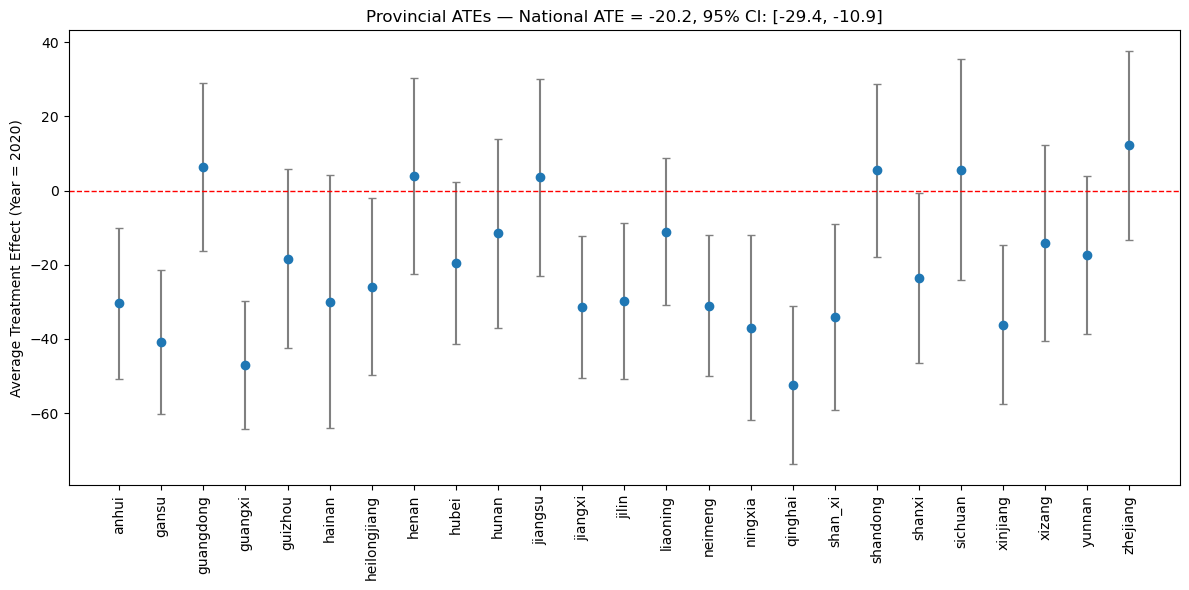

In [6]:
# Step 5: ATE summary and plot for post-treatment years
pltdat = filtered_data[filtered_data['year'] >= 2020]

# National ATE and SE
national_ate = pltdat['treatment_effect'].mean()
national_se = (pltdat['treatment_stderr']**2).mean()**0.5 / (len(pltdat)**0.5)
ci_lower = national_ate - 1.96 * national_se
ci_upper = national_ate + 1.96 * national_se

print(f"National ATE (Year ≥ 2020): {national_ate:.2f}")
print(f"Standard Error of National ATE: {national_se:.2f}")

print(f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")

# Provincial plot
ate_by_province = (
    pltdat
    .groupby('name')
    .agg(
        treatment_effect=('treatment_effect', 'mean'),
        treatment_se=('treatment_stderr', lambda x: (x**2).mean()**0.5 / (len(x)**0.5))
    )
    .reset_index()
    .sort_values(by='name')
)

plt.figure(figsize=(12, 6))
plt.errorbar(
    ate_by_province['name'],
    ate_by_province['treatment_effect'],
    yerr=ate_by_province['treatment_se'],
    fmt='o',
    ecolor='gray',
    capsize=3
)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xticks(rotation=90)
plt.ylabel('Average Treatment Effect (Year = 2020)')
plt.title(f'Provincial ATEs — National ATE = {national_ate:.1f}, 95% CI: [{ci_lower:.1f}, {ci_upper:.1f}]')
plt.tight_layout()
plt.show()

"We model the change in health expenditures as a function of treatment status, controlling for lagged covariates including GDP, patient volume, and ecological region. This setup weakens the parallel trends assumption by conditioning on relevant confounders, allowing for conditional identification of the treatment effect under the assumption that—conditional on observables—outcome trends for treated and untreated provinces would have evolved similarly in the absence of treatment."

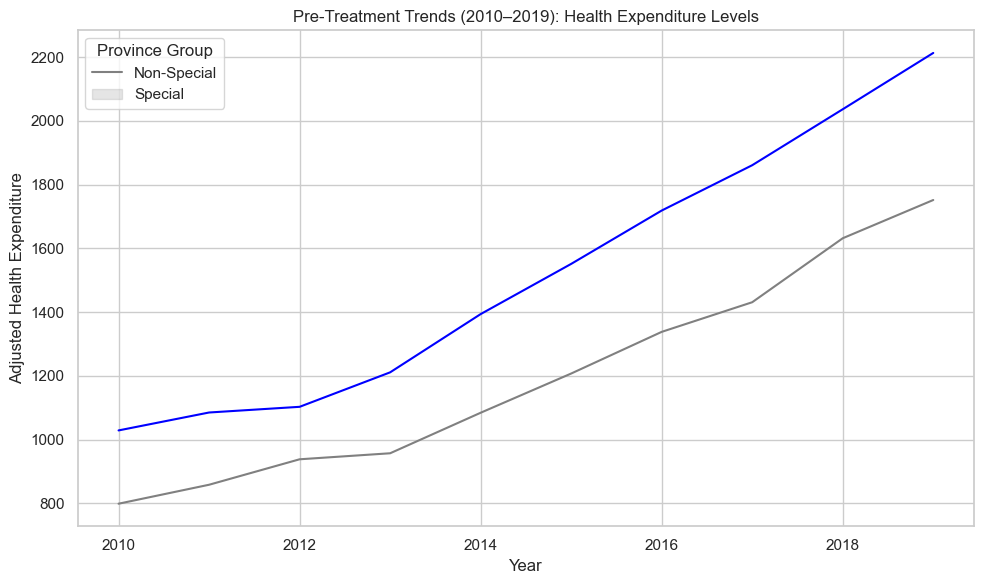

In [35]:
special_provinces = ['beijing', 'tianjin', 'shanghai', 'chongqing', 'fujian', 'hebei']
filtered_data['special'] = filtered_data['name'].str.lower().isin(special_provinces).astype(int)
pretrend_data = filtered_data[(filtered_data['year'] >= 2010) & (filtered_data['year'] <= 2019)]
avg_trends = (
    pretrend_data
    .groupby(['year', 'special'])['hexpf_adjusted']
    .mean()
    .reset_index()
)
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_trends, x='year', y='hexpf_adjusted', hue='special', palette=['gray', 'blue'])

plt.title("Pre-Treatment Trends (2010–2019): Health Expenditure Levels")
plt.ylabel("Adjusted Health Expenditure")
plt.xlabel("Year")
plt.legend(title='Province Group', labels=['Non-Special', 'Special'])
plt.tight_layout()
plt.show()

In [39]:
import statsmodels.formula.api as smf

pretrend_data['year'] = pretrend_data['year'].astype('category')
year_order = [2018] + sorted([y for y in pretrend_data['year'].cat.categories if y != 2018])
pretrend_data['year'] = pretrend_data['year'].cat.reorder_categories(year_order, ordered=True)
model = smf.ols("hexpf_adjusted ~ C(year) * special", data=pretrend_data).fit()
summary_df = model.summary2().tables[1].reset_index()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


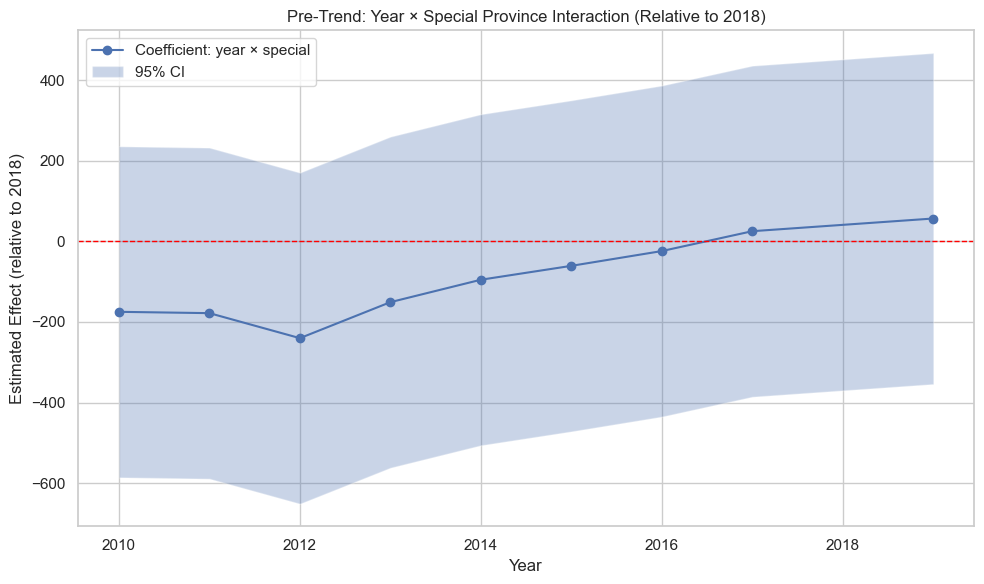

In [40]:
# Keep only interaction terms: C(year)[T.XXXX]:special
interaction_df = summary_df[summary_df['index'].str.contains(':special')].copy()

# Extract year number from 'C(year)[T.201X]:special'
interaction_df['year'] = interaction_df['index'].str.extract(r'\[T\.(\d+)\]').astype(int)

# Rename columns for clarity
interaction_df.rename(columns={'Coef.': 'coef', 'Std.Err.': 'stderr'}, inplace=True)

# Compute confidence intervals
interaction_df['ci_lower'] = interaction_df['coef'] - 1.96 * interaction_df['stderr']
interaction_df['ci_upper'] = interaction_df['coef'] + 1.96 * interaction_df['stderr']
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(interaction_df['year'], interaction_df['coef'], marker='o', label='Coefficient: year × special')
plt.fill_between(interaction_df['year'], interaction_df['ci_lower'], interaction_df['ci_upper'], alpha=0.3, label='95% CI')
plt.axhline(0, color='red', linestyle='--', linewidth=1)

plt.title('Pre-Trend: Year × Special Province Interaction (Relative to 2018)')
plt.xlabel('Year')
plt.ylabel('Estimated Effect (relative to 2018)')
plt.legend()
plt.tight_layout()
plt.show()

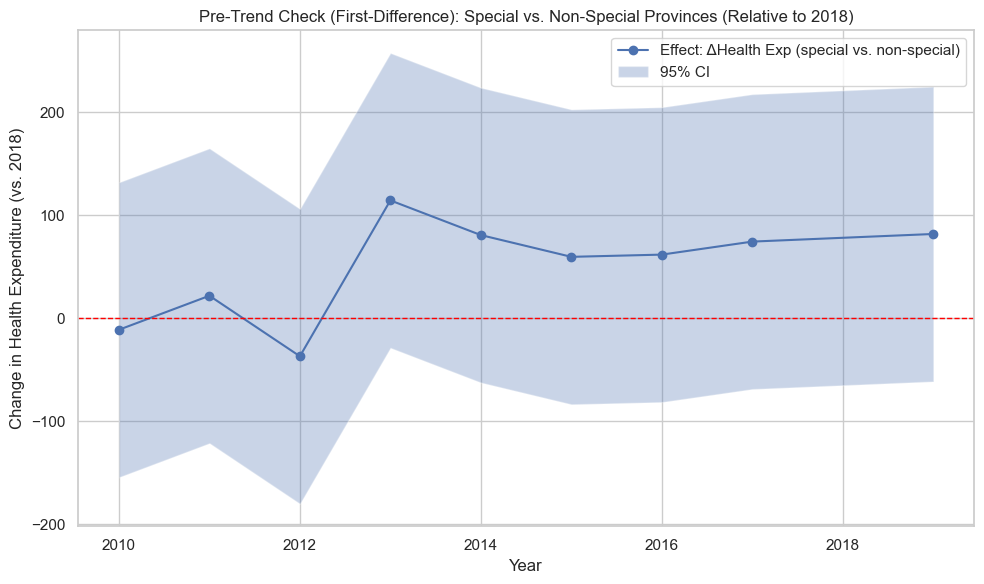

In [41]:
# Sort by unit and time
filtered_data = filtered_data.sort_values(by=['name', 'year']).reset_index(drop=True)

# Create first-difference of the outcome
filtered_data['hexpf_diff'] = filtered_data.groupby('name')['hexpf_adjusted'].diff()
special_provinces = ['beijing', 'tianjin', 'shanghai', 'chongqing', 'fujian', 'hebei']
filtered_data['special'] = filtered_data['name'].str.lower().isin(special_provinces).astype(int)

pretrend_data = filtered_data[(filtered_data['year'] >= 2010) & (filtered_data['year'] <= 2019)].copy()
pretrend_data = pretrend_data.dropna(subset=['hexpf_diff'])
pretrend_data['year'] = pretrend_data['year'].astype('category')
year_order = [2018] + sorted([y for y in pretrend_data['year'].cat.categories if y != 2018])
pretrend_data['year'] = pretrend_data['year'].cat.reorder_categories(year_order, ordered=True)
model = smf.ols("hexpf_diff ~ C(year) * special", data=pretrend_data).fit()
summary_df = model.summary2().tables[1].reset_index()
# Extract year × special interaction coefficients
interaction_df = summary_df[summary_df['index'].str.contains(':special')].copy()
interaction_df['year'] = interaction_df['index'].str.extract(r'\[T\.(\d+)\]').astype(int)
interaction_df.rename(columns={'Coef.': 'coef', 'Std.Err.': 'stderr'}, inplace=True)

# Confidence intervals
interaction_df['ci_lower'] = interaction_df['coef'] - 1.96 * interaction_df['stderr']
interaction_df['ci_upper'] = interaction_df['coef'] + 1.96 * interaction_df['stderr']
plt.figure(figsize=(10, 6))
plt.plot(interaction_df['year'], interaction_df['coef'], marker='o', label='Effect: ΔHealth Exp (special vs. non-special)')
plt.fill_between(interaction_df['year'], interaction_df['ci_lower'], interaction_df['ci_upper'], alpha=0.3, label='95% CI')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Pre-Trend Check (First-Difference): Special vs. Non-Special Provinces (Relative to 2018)')
plt.xlabel('Year')
plt.ylabel('Change in Health Expenditure (vs. 2018)')
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from econml.dml import DML
from sklearn.linear_model import Lasso
## ML Treatment
file_path = 'F:/PhD/2nd Year Paper/Data/filtered_data.csv'  # Update this to the correct path if needed
data = pd.read_csv(file_path)
filtered_data = data.dropna(subset=['hexpf_adjusted'])
filtered_data.loc[:, 'mltreat'] = (filtered_data['treatols19'] | filtered_data['treatols20']).astype(int)
filtered_data.loc[:, 'year'] = pd.to_numeric(filtered_data['year'], errors='coerce')  # Convert year to numeric
filtered_data['mltreat'] = filtered_data['mltreat'].astype(int)

C:\Users\yizho\AppData\Local\Temp\ipykernel_12836\3627143791.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'mltreat'] = (filtered_data['treatols19'] | filtered_data['treatols20']).astype(int)
C:\Users\yizho\AppData\Local\Temp\ipykernel_12836\3627143791.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['mltreat'] = filtered_data['mltreat'].astype(int)


In [51]:
# Load your actual dataset here
# filtered_data = pd.read_csv("your_data.csv")

# Mark special provinces
special_provinces = ['beijing', 'tianjin', 'shanghai', 'chongqing', 'fujian', 'hebei']
filtered_data['special'] = filtered_data['name'].str.lower().isin(special_provinces).astype(int)

# Drop the special provinces
filtered_data = filtered_data[filtered_data['special'] == 0].copy()

# Proceed with sorting
filtered_data = filtered_data.sort_values(by=['name', 'year']).reset_index(drop=True)
print("Number of observations:", filtered_data.shape[0])

Number of observations: 700


C:\Users\yizho\AppData\Local\Temp\ipykernel_12836\3245201112.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['special'] = filtered_data['name'].str.lower().isin(special_provinces).astype(int)


In [52]:
lag_vars = ['hexpf_adjusted', 'hos_num', 'annual_patient', 'gdp_adjusted', 'population']
for var in lag_vars:
    filtered_data[f'{var}_lag1'] = filtered_data.groupby('name')[var].shift(1)

# Drop rows with missing lags
filtered_data = filtered_data.dropna(subset=[f'{v}_lag1' for v in lag_vars])

print("Number of observations:", filtered_data.shape[0])

Number of observations: 475


# STEP 2: Split data
train_data = filtered_data[filtered_data['year'] < 2020].copy()
test_2020 = filtered_data[filtered_data['year'] >= 2020].copy()


# STEP 3: Create features
X_train = pd.concat([
    train_data[[f'{v}_lag1' for v in lag_vars]].copy(),
    train_data[['hos_num', 'annual_patient', 'gdp_adjusted', 'population', 'year']],
    pd.get_dummies(train_data['name'], drop_first=True)
], axis=1)
y_train = train_data['hexpf_adjusted']

X_2020 = pd.concat([
    test_2020[[f'{v}_lag1' for v in lag_vars]].copy(),
    test_2020[['hos_num', 'annual_patient', 'gdp_adjusted', 'population', 'year']],
    pd.get_dummies(test_2020['name'], drop_first=True)
], axis=1)
X_2020 = X_2020.reindex(columns=X_train.columns, fill_value=0)

In [53]:
# STEP 2: Split data
train_data = filtered_data[filtered_data['year'] < 2020].copy()
test_2020 = filtered_data[filtered_data['year'] >= 2020].copy()

# STEP 3: Create features
# Generate year dummies (as strings to prevent accidental numeric sorting)
year_dummies_train = pd.get_dummies(train_data['year'].astype(str), prefix='year', drop_first=True)
year_dummies_test = pd.get_dummies(test_2020['year'].astype(str), prefix='year', drop_first=True)

# Generate name (province) dummies
name_dummies_train = pd.get_dummies(train_data['name'], drop_first=True)
name_dummies_test = pd.get_dummies(test_2020['name'], drop_first=True)

# Combine features
X_train = pd.concat([
    train_data[[f'{v}_lag1' for v in lag_vars]],
    train_data[['hos_num', 'annual_patient', 'gdp_adjusted', 'population']],
    year_dummies_train,
    name_dummies_train
], axis=1)

X_2020 = pd.concat([
    test_2020[[f'{v}_lag1' for v in lag_vars]],
    test_2020[['hos_num', 'annual_patient', 'gdp_adjusted', 'population']],
    year_dummies_test,
    name_dummies_test
], axis=1)

# Ensure columns match between training and test sets
X_2020 = X_2020.reindex(columns=X_train.columns, fill_value=0)

# Outcome variable
y_train = train_data['hexpf_adjusted']

In [54]:
# STEP 4: Bootstrap prediction intervals
n_boot = 100
all_preds = []

for _ in range(n_boot):
    # Step 1: Resample training data
    boot_train = train_data.sample(frac=1.0, replace=True)

    # Step 2: Generate dummies using the same logic as original X_train
    year_dummies_boot = pd.get_dummies(boot_train['year'].astype(str), prefix='year', drop_first=True)
    name_dummies_boot = pd.get_dummies(boot_train['name'], drop_first=True)

    # Step 3: Construct feature matrix for bootstrap sample
    Xb = pd.concat([
        boot_train[[f'{v}_lag1' for v in lag_vars]],
        boot_train[['hos_num', 'annual_patient', 'gdp_adjusted', 'population']],
        year_dummies_boot,
        name_dummies_boot
    ], axis=1)

    # Step 4: Align columns to original X_train
    Xb = Xb.reindex(columns=X_train.columns, fill_value=0)

    # Step 5: Train model and predict on 2020 test set
    yb = boot_train['hexpf_adjusted']
    model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=None)
    model.fit(Xb, yb)
    pred_2020 = model.predict(X_2020)  # X_2020 already aligned earlier
    all_preds.append(pred_2020)

# STEP 5: Compute prediction means and intervals
all_preds = np.array(all_preds)
test_2020['pred_mean'] = all_preds.mean(axis=0)
test_2020['pred_lower'] = np.percentile(all_preds, 2.5, axis=0)
test_2020['pred_upper'] = np.percentile(all_preds, 97.5, axis=0)


# STEP 6: Treatment effect and CI
test_2020['treatment_effect'] = test_2020['hexpf_adjusted'] - test_2020['pred_mean']
test_2020['effect_ci_lower'] = test_2020['hexpf_adjusted'] - test_2020['pred_upper']
test_2020['effect_ci_upper'] = test_2020['hexpf_adjusted'] - test_2020['pred_lower']
test_2020['treatment_stderr'] = (test_2020['effect_ci_upper'] - test_2020['effect_ci_lower']) / (2 * 1.96)

National ATE (Year ≥ 2020): -78.75
Standard Error of National ATE: 6.36
95% CI: [-91.21, -66.29]


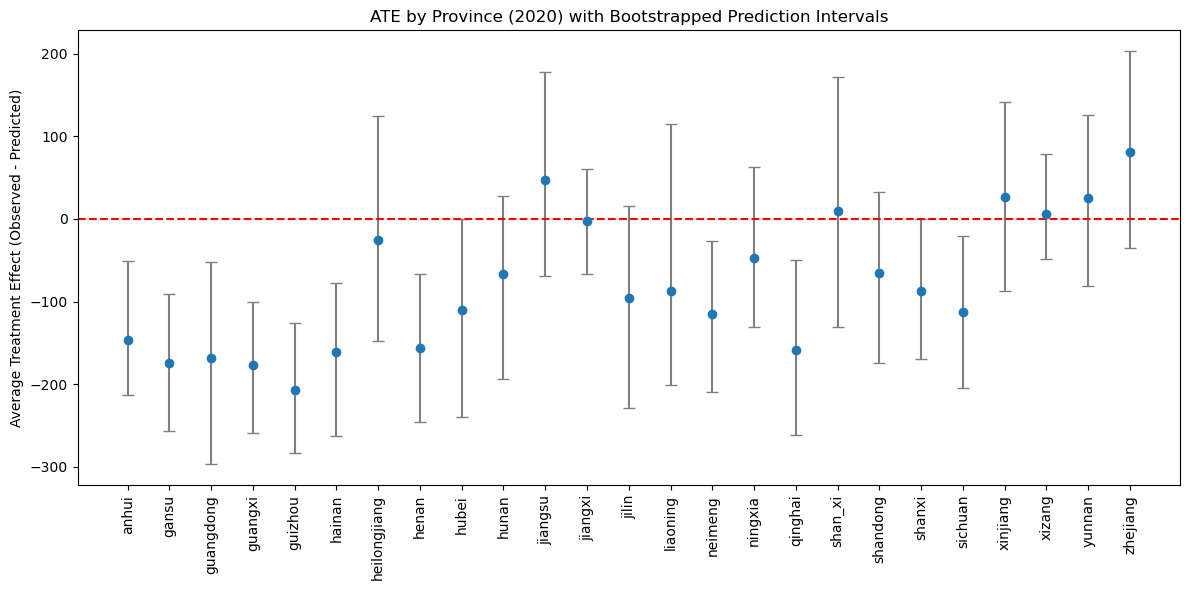

In [55]:
# National ATE and SE
national_ate = test_2020['treatment_effect'].mean()
national_se = (test_2020['treatment_stderr']**2).mean()**0.5 / (len(pltdat)**0.5)
ci_lower = national_ate - 1.96 * national_se
ci_upper = national_ate + 1.96 * national_se

print(f"National ATE (Year ≥ 2020): {national_ate:.2f}")
print(f"Standard Error of National ATE: {national_se:.2f}")

print(f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")

# STEP 7: Group by province and summarize
plot_df = (
    test_2020.groupby('name')[['treatment_effect', 'effect_ci_lower', 'effect_ci_upper']]
    .mean()
    .reset_index()
    .sort_values(by='name')
)

# STEP 8: Plot
plt.figure(figsize=(12, 6))
plt.errorbar(
    plot_df['name'],
    plot_df['treatment_effect'],
    yerr=[plot_df['treatment_effect'] - plot_df['effect_ci_lower'],
          plot_df['effect_ci_upper'] - plot_df['treatment_effect']],
    fmt='o', capsize=4, ecolor='gray'
)
plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=90)
plt.title("ATE by Province (>=S2020) with Bootstrapped Prediction Intervals")
plt.ylabel("Average Treatment Effect (Observed - Predicted)")
plt.tight_layout()
plt.show()